In [1]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Load data
train_data = pd.read_csv('/kaggle/input/mlpr-data-split/train.csv')
test_data = pd.read_csv('/kaggle/input/mlpr-data-split/test.csv')
holdout_data = pd.read_csv('/kaggle/input/mlpr-data-split/holdout.csv')

# Combine datasets for consistent encoding
data = pd.concat([train_data, test_data, holdout_data], ignore_index=True)

# Encoding using DAMAGE_PROPERTY (numerical, non-target variable)
categorical_cols = ['EVENT_TYPE', 'stability', 'WFO']
encoding_maps = {}

# Compute encoding mappings from training data using DAMAGE_PROPERTY
for col in categorical_cols:
    if col in train_data.columns:
        encoding_maps[col] = train_data.groupby(col)['ppt'].mean()

# Apply encoding to combined data
for col in categorical_cols:
    if col in data.columns:
        data[col + '_encoded'] = data[col].map(encoding_maps[col]).fillna(train_data['ppt'].mean())

# Split back into train, test, holdout
train_df = data.iloc[:len(train_data)]
test_df = data.iloc[len(train_data):len(train_data) + len(test_data)]
holdout_data = data.iloc[len(train_data) + len(test_data):]

In [ ]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import pandas as pd
import numpy as np

# Function to split and process a DataFrame
def process_df(df):
    # Create storm lagged severity-based DataFrames
    df_low = df[(df['is_storm_lagged'] == 1) & (df['severity_class'] == 0)].copy()
    df_medium = df[(df['is_storm_lagged'] == 1) & (df['severity_class'] == 1)].copy()
    df_high = df[(df['is_storm_lagged'] == 1) & (df['severity_class'] == 2)].copy()

    # Add is_outage flag
    for sub_df in [df_low, df_medium, df_high]:
        sub_df['is_outage'] = (sub_df['customers_out'] > 0).astype(int)

    # Process non-storm rows
    non_storm_data = df[df['is_storm_lagged'] == 0].copy()
    non_storm_data['is_outage'] = 0
    non_storm_data['severity_class'] = 10  # Placeholder

    # Shuffle and split non-storm rows
    non_storm_split = np.array_split(non_storm_data.sample(frac=1, random_state=42), 3)
    non_storm_low, non_storm_medium, non_storm_high = non_storm_split

    # Augment original DataFrames
    df_low = pd.concat([df_low, non_storm_low], ignore_index=True)
    df_medium = pd.concat([df_medium, non_storm_medium], ignore_index=True)
    df_high = pd.concat([df_high, non_storm_high], ignore_index=True)

    return df_low, df_medium, df_high

# Process both train and test DataFrames
train_low, train_medium, train_high = process_df(train_df)
test_low, test_medium, test_high = process_df(test_df)

outage_features = [
    'tmin', 'tmax', 'tavg', 'stability_encoded',
    'EVENT_TYPE_encoded', 'duration_hours', 'desc_word_count',
    'has_tornado', 'has_hail', 'has_flood', 'has_wind', 'has_tree',
    'has_broken', 'has_blown', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS',
    'INJURIES_DIRECT', 'DEATHS_DIRECT', 'CZ_FIPS'
]

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# Low Severity

[LightGBM] [Info] Number of positive: 22426, number of negative: 24427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 46853, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478646 -> initscore=-0.085468
[LightGBM] [Info] Start training from score -0.085468
Accuracy: 0.9783
Precision (weighted): 0.9784
Recall (weighted): 0.9783
F1 Score (weighted): 0.9783


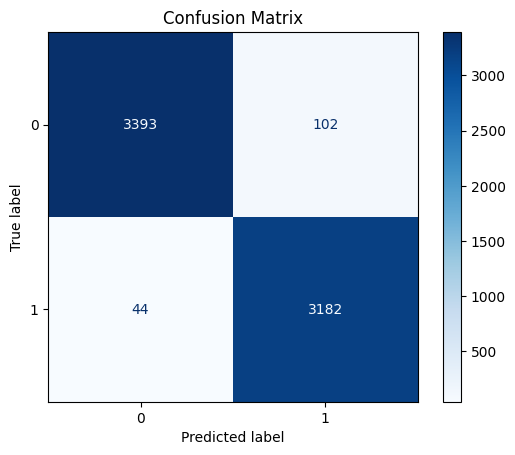

['/kaggle/working/low_severity_scaler.pkl']

In [3]:
import lightgbm as lgb

# ----------------- PREPARE FEATURES -----------------
X_train = train_low[outage_features]
y_train = train_low['is_outage']

X_test = test_low[outage_features]
y_test = test_low['is_outage']

# ----------------- SCALE FEATURES -----------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------- TRAIN MODEL -----------------
lgb_model = lgb.LGBMClassifier(
    n_estimators = 319,
    learning_rate = 0.047847333909262976,
    num_leaves = 281,
    max_depth = 20,
    min_child_samples = 22,
    subsample = 0.527136639688917,
    colsample_bytree = 0.8326768083509417,
    random_state = 42
)
lgb_model.fit(X_train_scaled, y_train)

# ----------------- EVALUATE -----------------
y_pred = lgb_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# ----------------- CONFUSION MATRIX -----------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ----------------- EXPORT MODEL AND SCALER -----------------
joblib.dump(lgb_model, '/kaggle/working/low_severity_lgm_model.pkl')
joblib.dump(scaler, '/kaggle/working/low_severity_scaler.pkl')

# Medium Severity

Accuracy: 0.9601
Precision (weighted): 0.9609
Recall (weighted): 0.9601
F1 Score (weighted): 0.9601


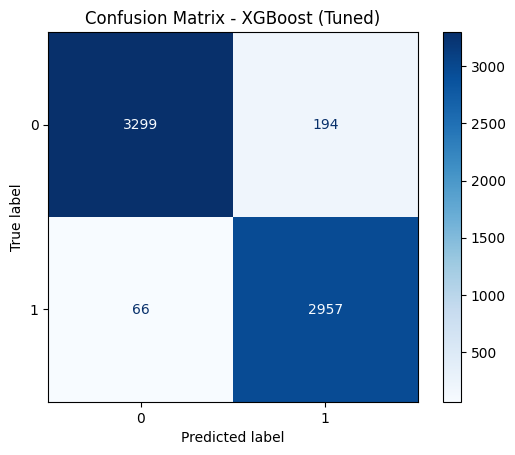

In [18]:
import xgboost as xgb
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score,
    recall_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ----------------- PREPARE FEATURES -----------------
X_train = train_medium[outage_features]
y_train = train_medium['is_outage']
X_test = test_medium[outage_features]
y_test = test_medium['is_outage']

# ----------------- SCALE FEATURES -----------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------- BEST PARAMETERS -----------------
best_params = {
    'n_estimators': 284,
    'max_depth': 15,
    'learning_rate': 0.07917066358756152,
    'subsample': 0.8015700617998658,
    'colsample_bytree': 0.5290123884596338,
    'gamma': 0.03854854253333355,
    'reg_alpha': 0.13733556293746432,
    'reg_lambda': 0.9769107444083599,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'n_jobs': -1
}

# ----------------- TRAIN FINAL MODEL -----------------
model = xgb.XGBClassifier(**best_params)
model.fit(X_train_scaled, y_train)

# ----------------- EVALUATE -----------------
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# ----------------- CONFUSION MATRIX -----------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost (Tuned)")
plt.show()

# High Severity

Accuracy: 0.9656
Precision (weighted): 0.9664
Recall (weighted): 0.9656
F1 Score (weighted): 0.9657


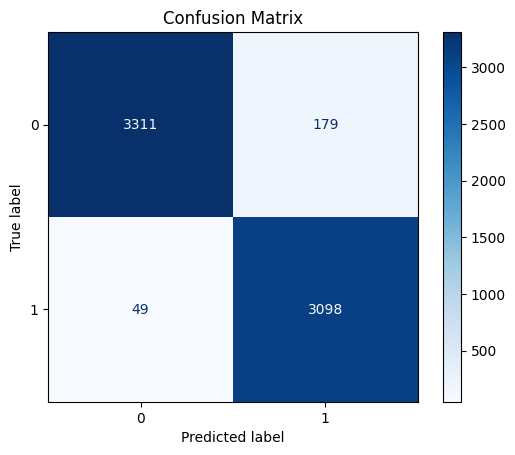

['/kaggle/working/high_severity_scaler.pkl']

In [5]:
# ----------------- PREPARE FEATURES -----------------
X_train = train_high[outage_features]
y_train = train_high['is_outage']

X_test = test_high[outage_features]
y_test = test_high['is_outage']

# ----------------- SCALE FEATURES -----------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------- TRAIN MODEL -----------------
rf_model = RandomForestClassifier(
    n_estimators=201,
    max_depth=38,
    min_samples_split=4,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# ----------------- EVALUATE -----------------
y_pred = rf_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# ----------------- CONFUSION MATRIX -----------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ----------------- EXPORT MODEL -----------------
joblib.dump(rf_model, '/kaggle/working/high_severity_rf_model.pkl')
joblib.dump(scaler, '/kaggle/working/high_severity_scaler.pkl')